In [23]:
import pandas as pd
import math
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

In [12]:
df = pd.read_csv("mushrooms.csv")

print("dataset shape:", df.shape)

dataset shape: (8124, 23)


# data preprocessing

In [13]:
# check duplicates 
duplicates = df.duplicated().sum()
if duplicates > 0: 
    df.drop_duplicates(inplace=True)

In [14]:
# check missing values 
missing = {}
for col in df.columns: 
    if '?' in df[col].unique(): 
        count = df[col].value_counts()['?']
        missing[col] = count 

print(f"missing data: {missing}")

missing data: {'stalk-root': np.int64(2480)}


In [15]:
# use mode to impute missing values 
for col in missing: 
    mode_val = df[col].mode()[0] 
    df[col] = df[col].replace('?', mode_val) 
    print(f"replaced '?' in {col} with {mode_val}")

replaced '?' in stalk-root with b


In [17]:
# check zero variance columns 
drop_cols = []
for col in df.columns: 
    if df[col].nunique() == 1: 
        drop_cols.append(col)

if drop_cols: 
    print(f"dropping zero variance columns (homogen or zero entropy): {drop_cols}")

dropping zero variance columns (homogen or zero entropy): ['veil-type']


In [18]:
# check balance
print(df['class'].value_counts(normalize=True))

class
e    0.517971
p    0.482029
Name: proportion, dtype: float64


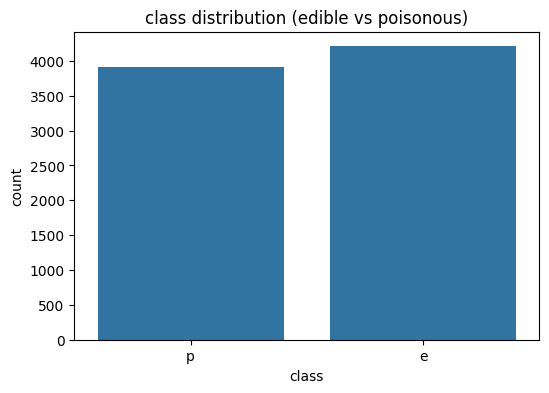

In [20]:
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df)
plt.title("class distribution (edible vs poisonous)")
plt.show()

# shannon entropy

In [33]:
def calculate_entropy(data_col): 
    counts = data_col.value_counts() 
    total_rows = len(data_col)  

    entropy = 0 
    for count in counts: 
        p_i = count / total_rows 

        if p_i > 0: 
            entropy += -p_i * math.log2(p_i)

    return entropy

# information gain

In [34]:
def calculate_information_gain(data, split_attribute, target_name='class'): 
    total_entropy = calculate_entropy(data[target_name]) 

    vals, counts = np.unique(data[split_attribute], return_counts=True) 
    weighted_entropy = 0 
    total_rows = len(data)

    for i in range(len(vals)):
        subset = data[data[split_attribute] == vals[i]] 
        prop = len(subset) / total_rows 
        subset_entropy = calculate_entropy(subset[target_name]) 
        weighted_entropy += prop * subset_entropy 
    
    # calculate gain 
    gain = total_entropy - weighted_entropy 
    return gain

# ID3

In [35]:
def id3(data, original_data, features, target_attribute_name="class", parent_node_class=None): 
    unique_classes = np.unique(data[target_attribute_name]) 
    if len(unique_classes) <= 1: 
        return unique_classes[0]
    
    elif len(data) == 0: 
        return np.unique(original_data[target_attribute_name])[np.argmax(np.unique(original_data[target_attribute_name], return_counts=True)[1])]
    
    elif len(features) == 0: 
        return parent_node_class
    
    else: 
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name], return_counts=True)[1])]

        item_values = [calculate_information_gain(data, feature, target_attribute_name) for feature in features]
        best_feature_idx = np.argmax(item_values)
        best_feature = features[best_feature_idx]

        tree = {best_feature: {}}

        features = [i for i in features if i != best_feature] 

        for value in np.unique(data[best_feature]): 
            sub_data = data.where(data[best_feature] == value).dropna()

            subtree = id3(sub_data, original_data, features, target_attribute_name, parent_node_class)

            tree[best_feature][value] = subtree

        return tree

In [36]:
training_data = df.sample(frac=0.8, random_state=42) 
test_data = df.drop(training_data.index)

training_data, test_data

(     class cap-shape cap-surface cap-color bruises odor gill-attachment  \
 1971     e         f           f         n       f    n               f   
 6654     p         f           s         e       f    y               f   
 5606     p         x           y         n       f    f               f   
 3332     e         f           y         g       t    n               f   
 6988     p         f           s         e       f    s               f   
 ...    ...       ...         ...       ...     ...  ...             ...   
 7830     e         k           s         g       f    n               f   
 5000     p         f           f         y       f    f               f   
 5853     p         b           s         w       t    n               f   
 1279     e         f           s         w       f    n               f   
 7250     p         k           s         n       f    y               f   
 
      gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
 1971        

In [37]:
features = df.columns[1:].tolist()
tree_model = id3(training_data, training_data, features, "class")

In [38]:
import pprint
print("Decision Tree Rules (First Level):")
pprint.pprint(tree_model, depth=2)

Decision Tree Rules (First Level):
{'odor': {'a': 'e',
          'c': 'p',
          'f': 'p',
          'l': 'e',
          'm': 'p',
          'n': {...},
          'p': 'p',
          's': 'p',
          'y': 'p'}}


# prediction and eval

In [ ]:
def predict(query, tree, default=None):
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][query[key]] 
            except:
                return default
  
            result = tree[key][query[key]]
            
            if isinstance(result, dict):
                return predict(query, result)
            else:
                return result

In [47]:
def test_accuracy(data, tree):
    queries = data.to_dict(orient="records")
    predicted = []
    for i in range(len(data)):
        predicted.append(predict(queries[i], tree, 'p'))
        
    actual = data["class"].tolist()
    
    correct = 0
    for i in range(len(actual)):
        if predicted[i] == actual[i]:
            correct += 1
    return correct / len(actual)

In [43]:
tree_model

{'odor': {'a': 'e',
  'c': 'p',
  'f': 'p',
  'l': 'e',
  'm': 'p',
  'n': {'spore-print-color': {'b': 'e',
    'h': 'e',
    'k': 'e',
    'n': 'e',
    'o': 'e',
    'r': 'p',
    'w': {'habitat': {'d': {'gill-size': {'b': 'e', 'n': 'p'}},
      'g': 'e',
      'l': {'cap-color': {'c': 'e', 'n': 'e', 'w': 'p', 'y': 'p'}},
      'p': 'e',
      'w': 'e'}},
    'y': 'e'}},
  'p': 'p',
  's': 'p',
  'y': 'p'}}

In [51]:
acc = test_accuracy(test_data, tree_model)
print(f"accuracy: {acc * 100:.2f}%")

accuracy: 100.00%
